# Setup

In [14]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2
from torchvision.models.resnet import ResNet18_Weights
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_size = 1000
test_size = 100
batch_size = 4

# Dataloader

In [15]:
class DMCDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform
        # print('Dataloader initialized')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image and mask
        # print('Loading image:', self.image_paths[idx])
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        # print('Images loaded')

        # Convert both image and mask to tensors, apply any specified transformations
        if self.transform:
            image = self.transform(image)
            mask = self.mask_transform(mask)

        # print('Images transformed to tensors')

        # Ensure mask is a binary tensor (0 or 1 values)
        mask = (mask > 0.5).float() # Threshold mask to binary if not already

        # print('Mask thresholded')

        return image, mask

### Custom Normalization

In [16]:
# transformation to convert images to tensors (no normalization yet)
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

# function to compute mean and std
def calculate_mean_std(image_paths, transform):
    channel_sum = torch.zeros(3)
    channel_squared_sum = torch.zeros(3)
    num_pixels = 0

    for path in image_paths:
        # load and transform the image
        image = Image.open(path).convert('RGB') # ensure 3-channel RGB images
        tensor = transform(image)

        # accumulate sum and squared sum of pixel values
        channel_sum += tensor.sum(dim=(1, 2))
        channel_squared_sum += (tensor ** 2).sum(dim=(1, 2))
        num_pixels += tensor.size(1) * tensor.size(2) # H * W

    # calculate mean and std
    mean = channel_sum / num_pixels
    std = ((channel_squared_sum / num_pixels) - mean ** 2).sqrt()

    return mean, std

# Compute mean and std for the dataset
# mean, std = calculate_mean_std(glob.glob('../data/synth_data/noisy/*.png')[:train_size], transform)
# print(f'Mean: {mean}')
# print(f'Std: {std}')

In [17]:
transform = v2.Compose([
    v2.Resize((512, 512), interpolation=InterpolationMode.BILINEAR), # Resize to match model input
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ResNet normalization
    # v2.Normalize(mean=mean, std=std) # custom normalization
])

mask_transform = v2.Compose([
    v2.Resize((512, 512), interpolation=InterpolationMode.BILINEAR), # Resize to match model input
    v2.Grayscale(num_output_channels=1), # ensure mask is grayscale
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [18]:
# Get paths to all images and masks
train_image_paths = glob.glob('../data/synth_data/noisy/*.png')[:train_size]
train_mask_paths = glob.glob('../data/synth_data/ground_truth/*.png')[:train_size]

test_image_paths = glob.glob('../data/synth_data/noisy/*.png')[-test_size:]
test_mask_paths = glob.glob('../data/synth_data/ground_truth/*.png')[-test_size:]

# Create dataset and dataloader
train_dataset = DMCDataset(train_image_paths, train_mask_paths, transform=transform, mask_transform=mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = DMCDataset(test_image_paths, test_mask_paths, transform=transform, mask_transform=mask_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


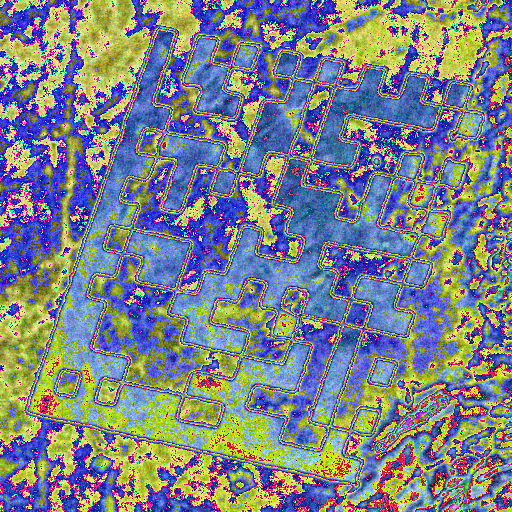

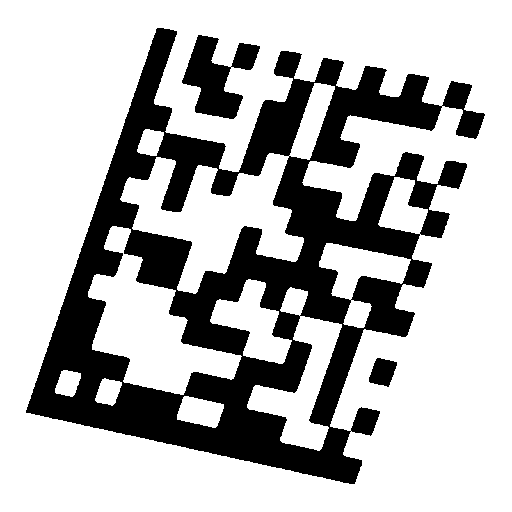

In [19]:
# train dataset example
for i, (image, mask) in enumerate(train_dataset):
    print(image.shape, mask.shape)
    break

# train Dataloader example
for i, (image, mask) in enumerate(train_dataloader):
    print(image.shape, mask.shape)
    image = v2.ToPILImage()(image[0].squeeze(0))
    display(image)

    mask = v2.ToPILImage()(mask[0].squeeze(0))
    display(mask)
    break

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


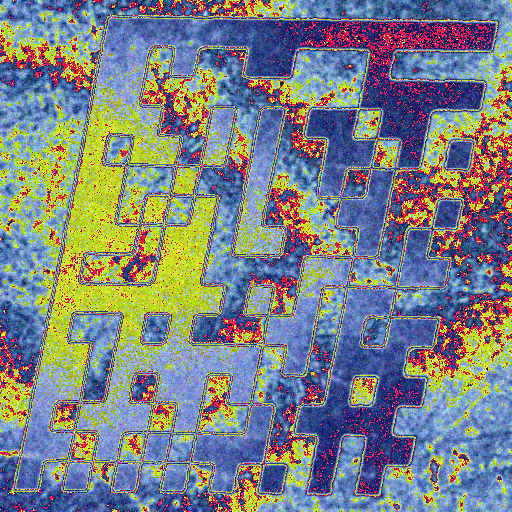

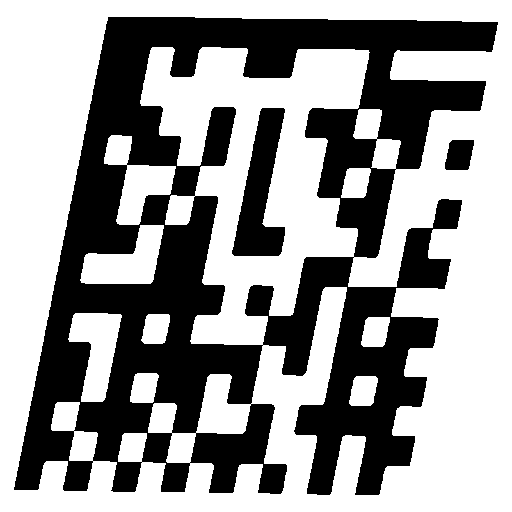

In [20]:
# test dataset example
for i, (image, mask) in enumerate(test_dataset):
    print(image.shape, mask.shape)
    break

# test Dataloader example
for i, (image, mask) in enumerate(test_dataloader):
    print(image.shape, mask.shape)
    image = v2.ToPILImage()(image[0].squeeze(0))
    display(image)

    mask = v2.ToPILImage()(mask[0].squeeze(0))
    display(mask)
    break

# Modifying Architecture

In [21]:
class binarizer(nn.Module):
    def __init__(self):
        super(binarizer, self).__init__()

        # Load the pretrained ResNet-18 model
        resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Use the ResNet layers up to the last layer (remove the fully connected layer)
        self.encoder = nn.Sequential(*list(resnet18.children())[:-2]) # output size = 512 x 8 x 8

        # Define the decoder part to upsample back to 512 x 512
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # Use sigmoid for binary output in range [0, 1]
        )

    def forward(self, x):
        '''Pass input through the resnet-18 encoder and custom decoder'''
        # print('FORWARD A')
        x = self.encoder(x)
        # print('FORWARD B')
        x = self.decoder(x)
        return x

# Training Loop

In [22]:
# Loss function - balances between two methods
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, output, target):
        smooth = 1.0  # To avoid division by zero
        output = output.contiguous().view(-1)
        target = target.contiguous().view(-1)
        intersection = (output * target).sum()
        dice = (2. * intersection + smooth) / (output.sum() + target.sum() + smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=1, dice_weight=1, bce_class_weights=None):
        super(BCEDiceLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCELoss(weight=bce_class_weights)
        self.dice = DiceLoss()

    def forward(self, output, target):
        bce_loss = self.bce(output, target)
        dice_loss = self.dice(output, target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

In [23]:
# somehow causes loss to be 0
def calculate_bce_class_weights(batch, black_pixel_factor, white_pixel_factor):
    '''Calculate class weights for BCE loss based on batch'''
    # Calculate class weights for BCE loss
    class_weights = batch.clone()
    for mask in batch:
        class_weights[0] += (mask == 0).sum()
        class_weights[1] += (mask == 1).sum()

    # Apply black pixel factor to class 0
    class_weights[0] *= black_pixel_factor
    class_weights[1] *= white_pixel_factor

    # Normalize class weights
    class_weights = class_weights / class_weights.sum()

    return class_weights

In [24]:
# setup
model = binarizer().to(device)

# params
num_epochs = 10

# Optimizer - try with others
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.000001) # binarizer_5
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001) # binarizer_6
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.0, weight_decay=0.0) # binarizer_7 (SGD with no momentum) (too small learning rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.0, weight_decay=0.0) # binarizer_8 (SGD with no momentum and higher LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.0, weight_decay=0.0) # binarizer_9 (SGD with no momentum and higher LR, 5.0 black pixel factor)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.000001) # binarizer_10 (Adam with weight decay, 5.0 black pixel factor)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.000001) # binarizer_11 (Adam with weight decay, 2.0 black pixel factor)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.000001) # binarizer_12 (Adam with weight decay, 1.0 black pixel factor)
# binarizer_13 (same as above but with only dice loss) <- best so far
# binarizer_14 (same as above but with only bce loss)
# binarizer_15 (same as above but with equal dice and bce loss)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001) # binarizer_16 (Adam with higher weight decay, only dice loss)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.000001) # binarizer_17 (same as 13 but no custom normalization)

# attempting to replicate binarizer_0
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [25]:
# Actual training loop
prev_loss = 999999
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    count = 0
    for inputs, masks in train_dataloader: # consider renaming masks to targets
        inputs, masks = inputs.to(device), masks.to(device)

        # Forward pass
        outputs = model(inputs) # Add batch dimension to input

        # Calculate weights for BCE loss
        # bce_class_weights = calculate_bce_class_weights(masks, black_pixel_factor=1.0, white_pixel_factor=1.0) # make black pixels more important
        criterion = BCEDiceLoss(bce_weight=1.0, dice_weight=1.0, bce_class_weights=None) # prefers dice loss

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        count += batch_size
        print(f'{count}/{train_size}', end='\r')

        # if count >= 10:
            # break

    # early stopping if loss increases or stops decreasing - this allows to use a large number of epochs
    if running_loss > prev_loss or prev_loss - running_loss < 0.0001:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}')
        print('Stopped early')
        break
    prev_loss = running_loss

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}')

    # Save the model
    torch.save(model.state_dict(), '../torch/binarizer_18.pt')

Epoch [1/10], Loss: 0.7061
Epoch [2/10], Loss: 0.5410
Epoch [3/10], Loss: 0.3935
Epoch [4/10], Loss: 0.3029
Epoch [5/10], Loss: 0.2421
Epoch [6/10], Loss: 0.2105
Epoch [7/10], Loss: 0.1722
Epoch [8/10], Loss: 0.1554
Epoch [9/10], Loss: 0.1371
Epoch [10/10], Loss: 0.1242


# Evaluation

Output range: min=1.3035254819993014e-10, max=1.0
Output range after binarization: min=0.0, max=1.0
Mean IoU: 0.2274
Mean Dice Coefficient: 0.2378
Mean Pixel Accuracy: 0.2332


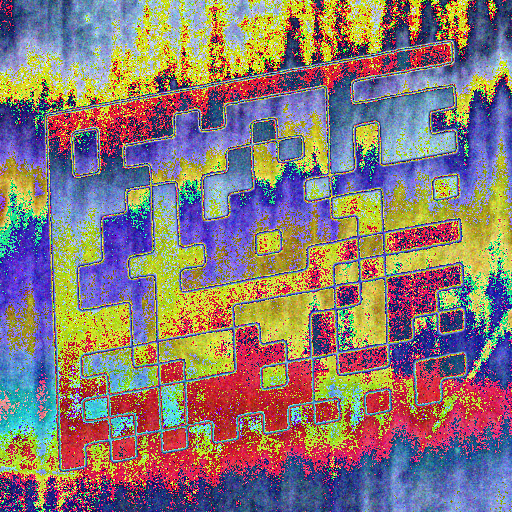

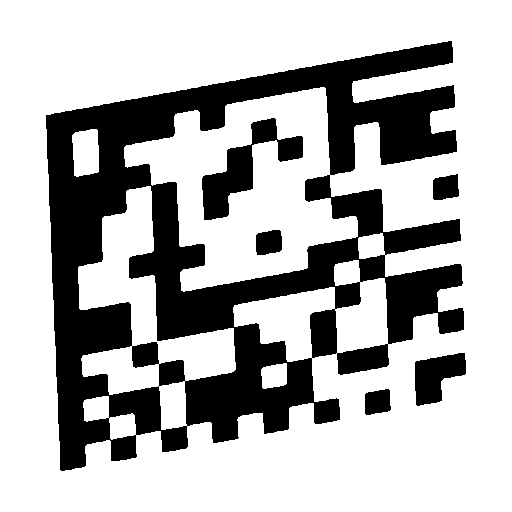

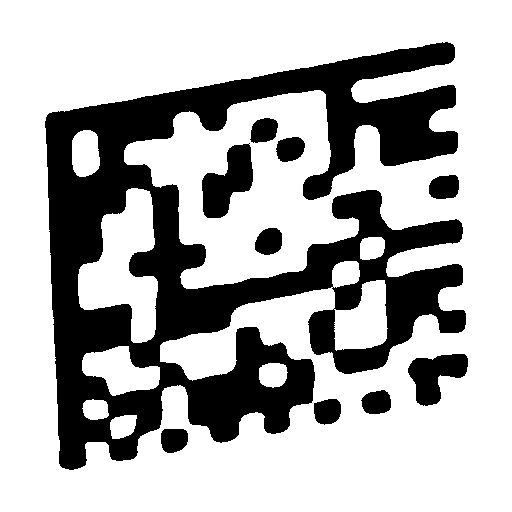

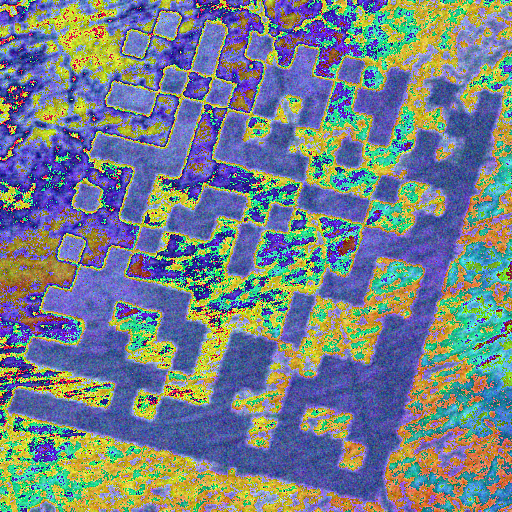

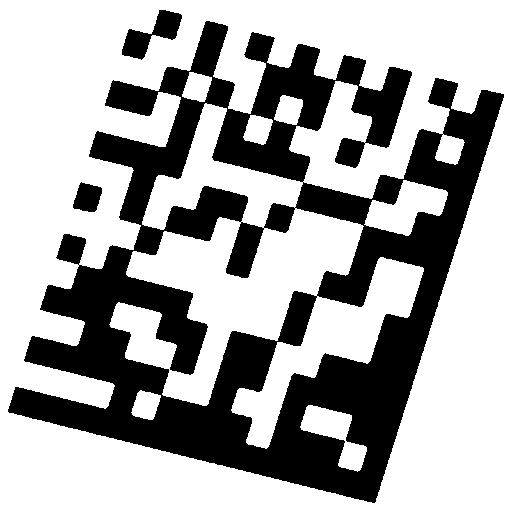

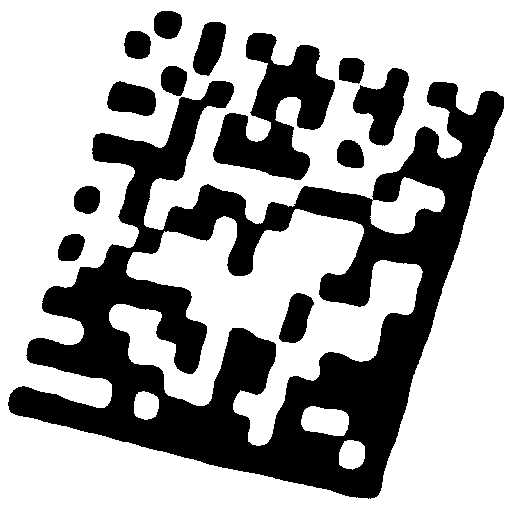

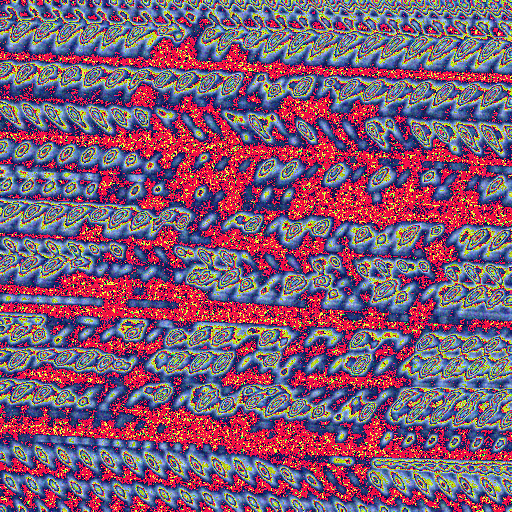

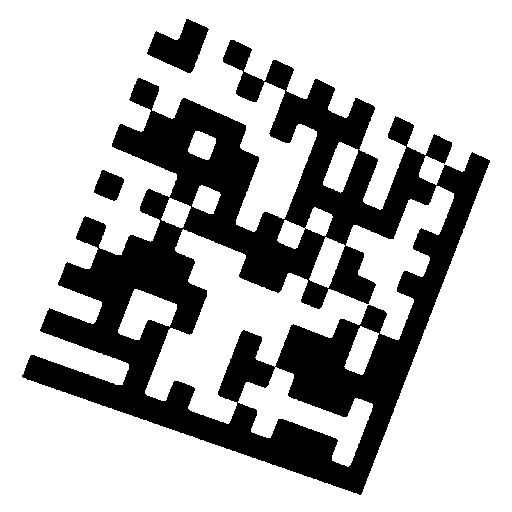

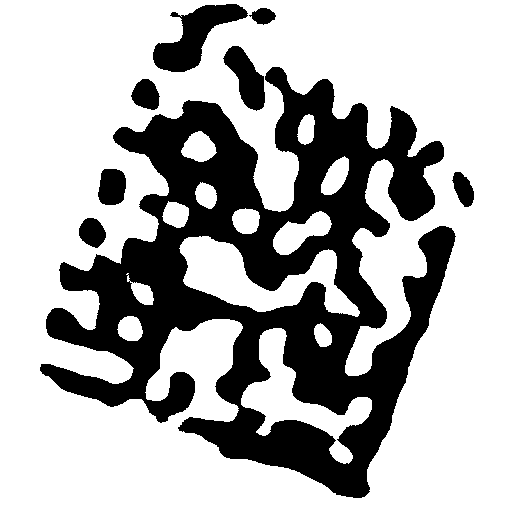

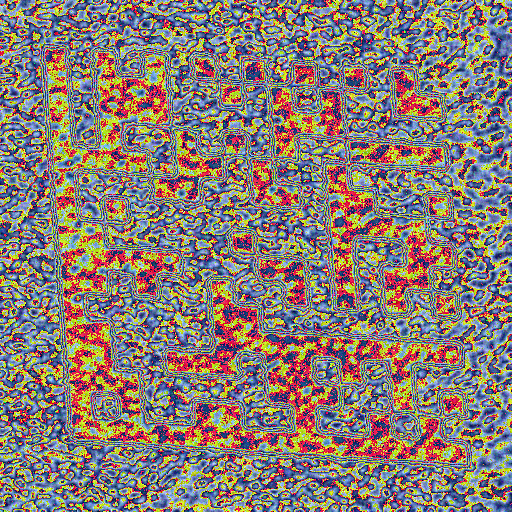

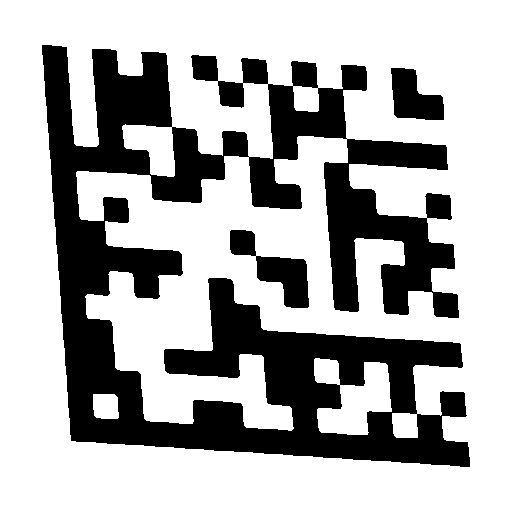

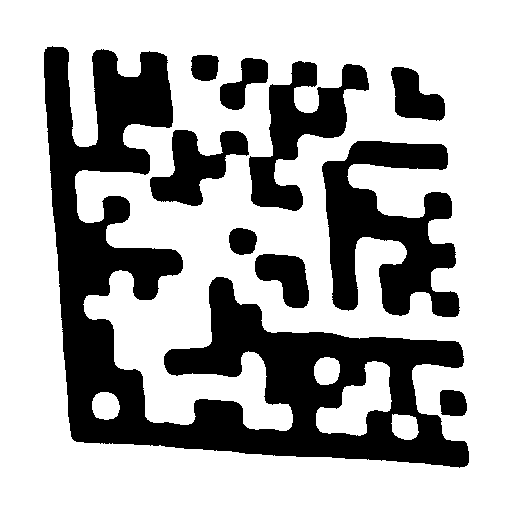

(0.22736845374107362, 0.23775135695934296, 0.23323408126831055)

In [26]:
# Assuming you have a test DataLoader providing (images, ground_truth_masks)
def evaluate_model(model, test_loader, threshold=0.5):
    model.eval()  # Set model to evaluation mode

    iou_total = 0
    dice_total = 0
    accuracy_total = 0
    count = 0

    with torch.no_grad():  # No need to compute gradients for evaluation
        for images, ground_truths in test_loader:
            # Move data to the same device as the model
            images = images.to(device)
            ground_truths = ground_truths.to(device)

            # Forward pass
            outputs = model(images)

            # Binarize the outputs
            predictions = (outputs > threshold).float() # Binarize predictions

            # predictions = outputs # inspect the output pre binarization

            # Calculate IoU
            intersection = (predictions * ground_truths).sum((1, 2, 3))
            union = (predictions + ground_truths).sum((1, 2, 3)) - intersection
            iou = (intersection / union).mean()  # Mean IoU for batch
            iou_total += iou.item()

            # Calculate Dice Coefficient
            dice = (2 * intersection / (predictions.sum((1, 2, 3)) + ground_truths.sum((1, 2, 3)))).mean()
            dice_total += dice.item()

            # Calculate Pixel Accuracy
            correct = (predictions == ground_truths).float().sum()
            accuracy = correct / ground_truths.numel()
            accuracy_total += accuracy.item()

            count += batch_size
            print(f'{count}/{test_size}', end='\r')

            if count >= 100:
                break

    # debug print
    print(f'Output range: min={outputs.min().item()}, max={outputs.max().item()}')
    print(f'Output range after binarization: min={predictions.min().item()}, max={predictions.max().item()}')

    # Average the metrics over the whole test set
    mean_iou = iou_total / count
    mean_dice = dice_total / count
    mean_accuracy = accuracy_total / count

    print(f'Mean IoU: {mean_iou:.4f}')
    print(f'Mean Dice Coefficient: {mean_dice:.4f}')
    print(f'Mean Pixel Accuracy: {mean_accuracy:.4f}')

    # show batch of images
    for i in range(4):
        image = v2.ToPILImage()(images[i].squeeze(0))
        mask = v2.ToPILImage()(ground_truths[i].squeeze(0))
        pred = v2.ToPILImage()(predictions[i].squeeze(0))
        display(image)
        display(mask)
        display(pred)

        # image.save('../figures/binarization/failure_noisy.png')
        # mask.save('../figures/binarization/failure_ground_truth.png')
        # pred.save('../figures/binarization/failure_prediction.png')

    return mean_iou, mean_dice, mean_accuracy

evaluate_model(model, test_dataloader, threshold=0.5)